In [2]:
from utils import *

In [3]:
data = pd.read_excel("all-in-one.xlsx")
# for i in ("Make", "Variant", "Country/Region/State ", "Geographic Region"):
#     data[i] = data[i].astype(str).apply(lambda x: x.strip())
# data["relative"] = (data["rf_HK_Price"] - data["Listing Price (USD)"]) / data["Listing Price (USD)"]
# data.to_excel("all-in-one.xlsx", index=False)
regions = np.unique(data["Geographic Region"])
data.dtypes

Listing Price (USD)          int64
Length(ft)                 float64
Year                         int64
LWL (ft)                   float64
Beam (ft)                  float64
Draft (ft)                 float64
Displacement (lbs)           int64
Sail area (sq ft)            int64
ACT(tons)                    int64
GDP (USD billion)          float64
GDP per capita (USD)         int64
Logistics costs to GDP%    float64
Type                         int64
Make                        object
Variant                     object
Geographic Region           object
Country/Region/State        object
rf_HK_Price                float64
relative                   float64
dtype: object

### 数据分类

In [148]:
for shipType, key in product((0, 1), ("Country/Region/State ", "Make", "Geographic Region", "Variant")):
    shipMask = data["Type"] == shipType
    fatherKey = {
        "Variant": "Make",
        "Country/Region/State ": "Geographic Region",
    }.get(key)
    groupBy, r_index = np.unique(data[key], return_index=True)
    choose = [any((data[key] == i) & shipMask) for i in groupBy]
    groupBy, r_index = groupBy[choose], r_index[choose]
    groupBy = pd.DataFrame(
        data={
            key: groupBy,
            "aberration": [
                data["relative"][(data[key] == region) & shipMask].mean()
                for region in groupBy
            ],
        }
    )
    if fatherKey is not None:
        groupBy.insert(0, fatherKey, [data[fatherKey][i] for i in r_index])
    # print(shipType, key, groupBy.shape)
    groupBy.to_excel(f"grouped/{'双体' if shipType else '单体'} grouped by {key.replace('/', '-')}.xlsx", index=False)


In [129]:
shipType = 0
threeComp = filter(
    lambda x: data["Geographic Region"][
        (data["Make"] == x) & (data["Type"] == shipType)
    ].nunique()
    == 3,
    data["Make"].unique(),
)
threeComp = list(threeComp)
table1 = pd.DataFrame(index=threeComp, columns=regions)
for make, area in product(table1.index, table1.columns):
    table1[area][make] = data["relative"][
        (data["Make"] == make) & (data["Geographic Region"] == area)
    ].mean()
table1.to_excel(f"grouped/{'双体' if shipType else '单体'} maker and area.xlsx")


In [167]:
key = "Country/Region/State "
uni = np.unique(data[key])
uni = {i: sum(data[key] == i) for i in uni}
toBeSort = data[key].apply(lambda x: uni[x])
order = np.argsort(toBeSort)
pd.DataFrame(
    {key: data[key][order], "Listing Price (USD)": data["Listing Price (USD)"][order]}
).to_excel("sorted.xlsx")


### 作图

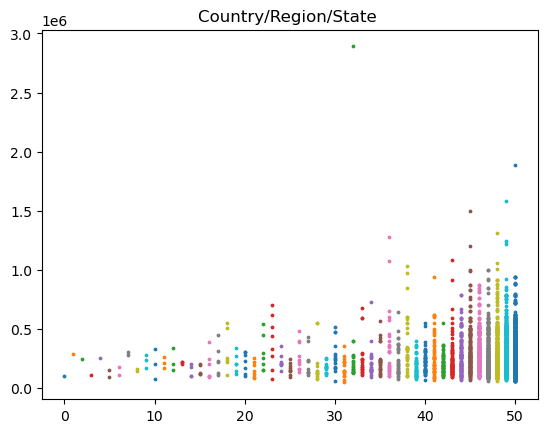

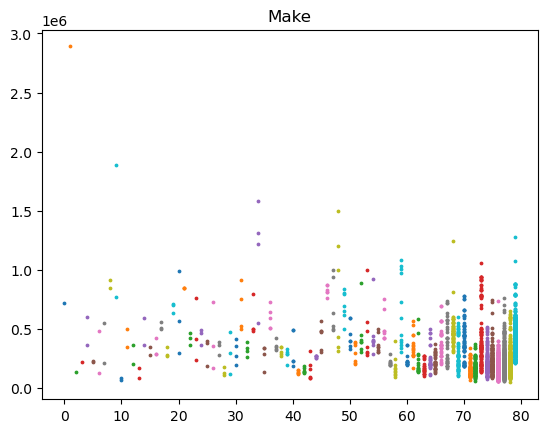

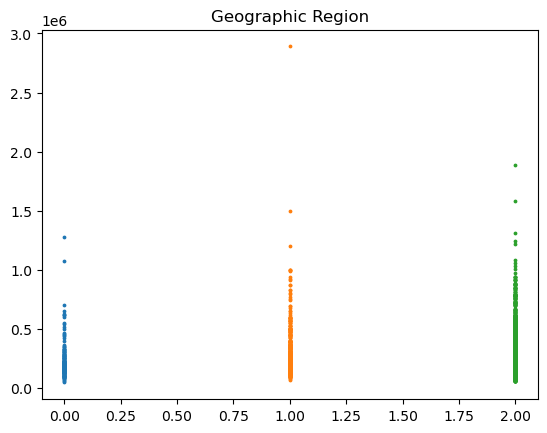

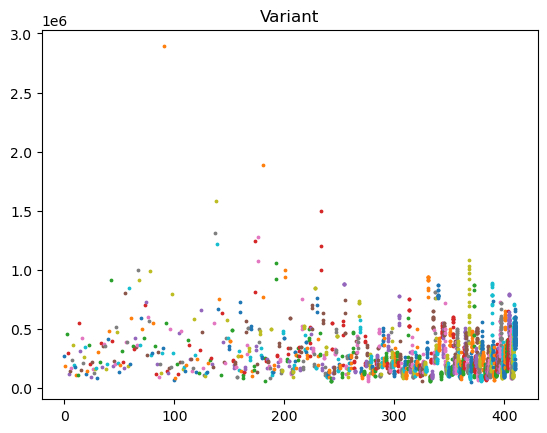

In [168]:
for key in ("Country/Region/State ", "Make", "Geographic Region", "Variant"):
    yAxis = np.unique(data[key])
    yAxis = sorted(yAxis, key=lambda x:sum(data[key]==x))
    plt.figure()
    for i, ele in enumerate(yAxis):
        y = data["Listing Price (USD)"][data[key]==ele]
        plt.title(key)
        plt.scatter(np.full_like(y, i), y, s=3)


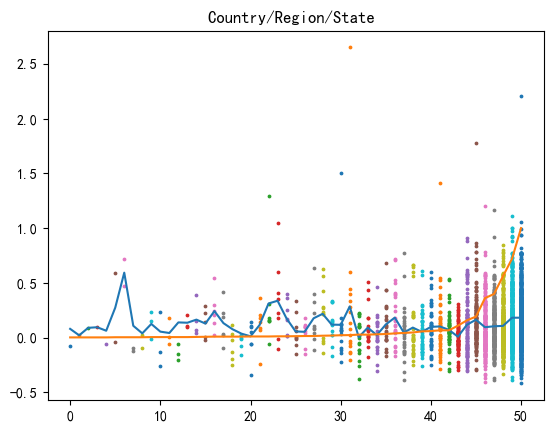

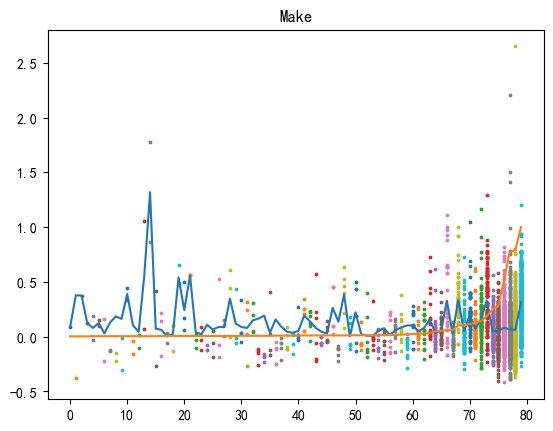

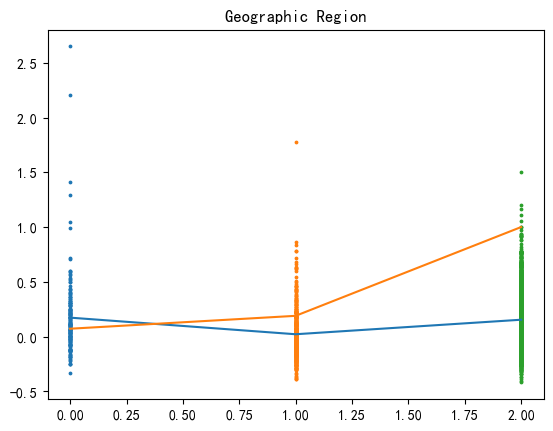

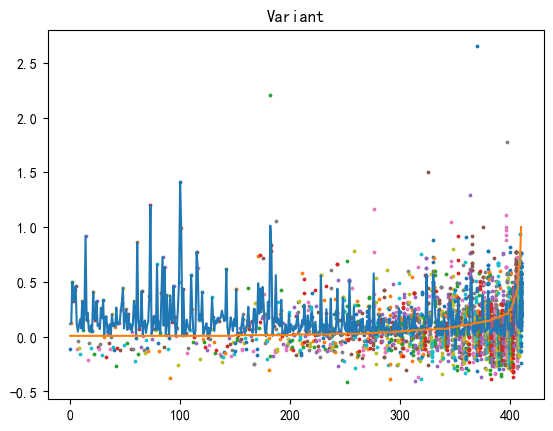

In [10]:
for key in ("Country/Region/State ", "Make", "Geographic Region", "Variant"):
    yAxis = np.unique(data[key])
    yAxis = sorted(yAxis, key=lambda x:sum(data[key]==x))
    # yAxis = sorted(yAxis, key=lambda x:abs(data["relative"][data[key]==x].mean()))
    plt.figure()
    for i, ele in enumerate(yAxis):
        y = data["relative"][data[key]==ele]
        plt.title(key)
        plt.scatter(np.full_like(y, i), y, s=3)
    mean = [abs(data["relative"][data[key]==i].mean()) for i in yAxis]
    plt.plot(range(len(mean)), mean)
    num = np.array([sum(data[key]==i) for i in yAxis])
    plt.plot(range(len(num)), num/num.max())

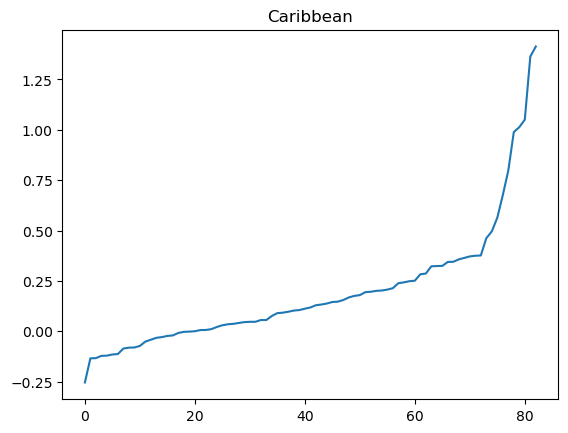

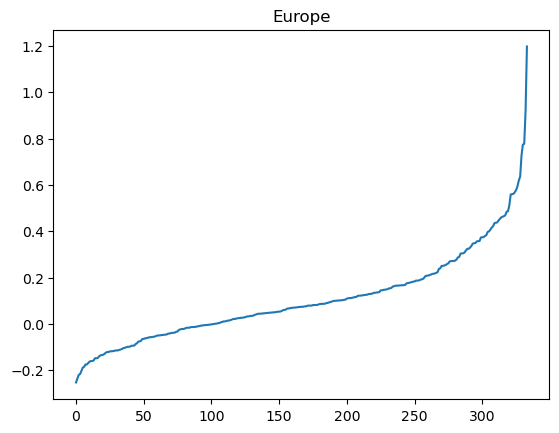

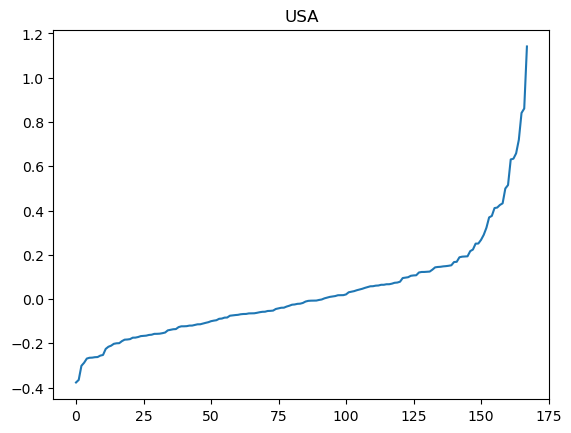

In [14]:
# 不同区域的品种的平均区域效应，已排序
with pd.ExcelWriter("grouped/regional effect by area.xlsx") as f:
    key = "Variant"
    for area in regions:
        data_ = data.loc[data["Geographic Region"] == area]
        xAxis = np.unique(data_[key])
        xAxis = sorted(xAxis, key=lambda x: data_["relative"][data_[key] == x].mean())
        yAxis = [data_["relative"][data_[key] == x].mean() for x in xAxis]
        plt.figure()
        plt.title(area)
        plt.plot(yAxis)
        pd.DataFrame({key: xAxis, "re": yAxis}).to_excel(
            f, sheet_name=area, index=False
        )


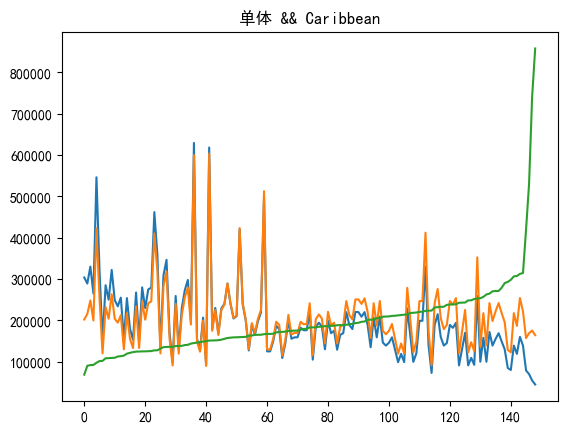

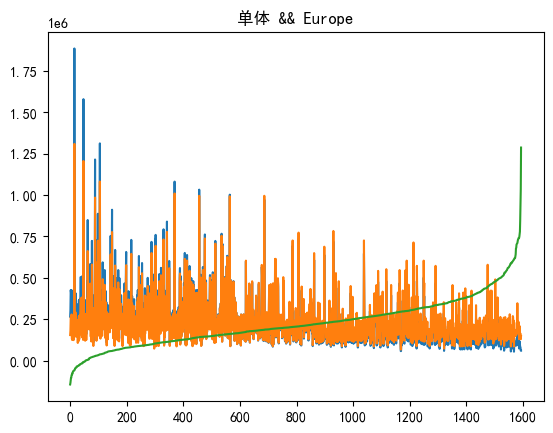

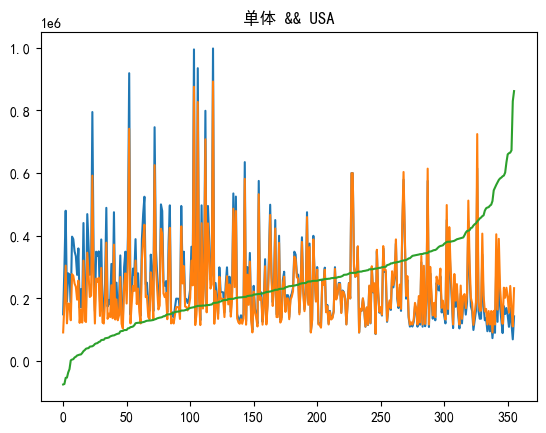

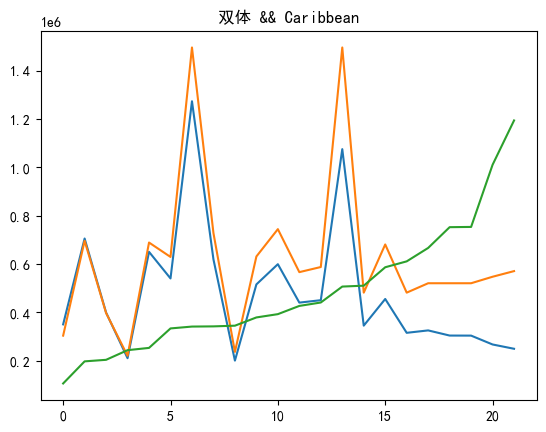

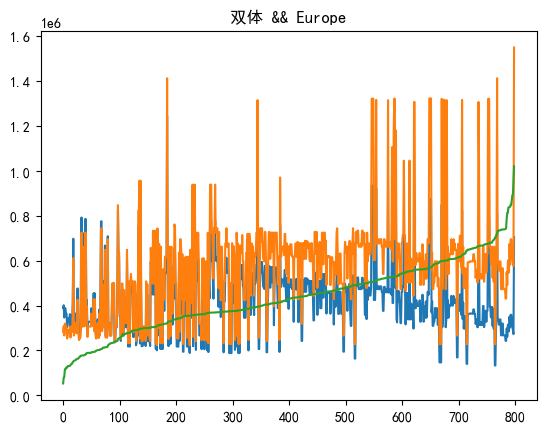

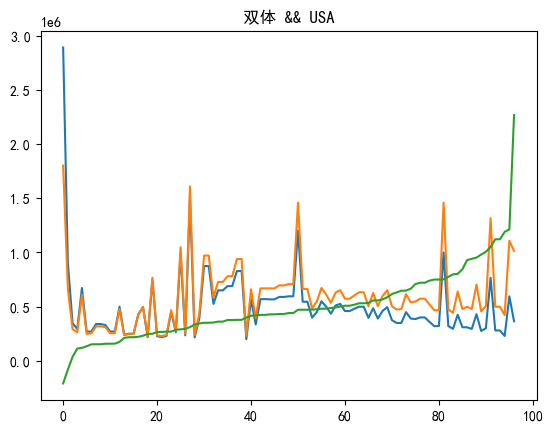

In [8]:
# 不同区域两种船的 (原价, 香港价, 区域效应)，依据区域效应排序
with pd.ExcelWriter("grouped/price info by area and type.xlsx") as f:
    for shipType, area in product((0, 1), regions):
        data_ = data.loc[
            (data["Type"] == shipType) & (data["Geographic Region"] == area)
        ]
        price, hk_price, re = (
            data_["Listing Price (USD)"],
            data_["rf_HK_Price"],
            data_["relative"],
        )
        order = np.argsort(re)
        price, hk_price, re = price.iloc[order], hk_price.iloc[order], re.iloc[order]
        plt.figure()
        plt.title(f"{'双体' if shipType else '单体'} && {area}")
        plt.plot(range(len(re)), price)
        plt.plot(range(len(re)), hk_price)
        plt.plot(
            range(len(re)), (re - re.mean()) / re.std() * price.std() + price.mean()
        )
        pd.DataFrame(
            {"price": price, "hongKong price": hk_price, "regional effect": re}
        ).to_excel(f, sheet_name=f"{'双体' if shipType else '单体'} && {area}", index=False)


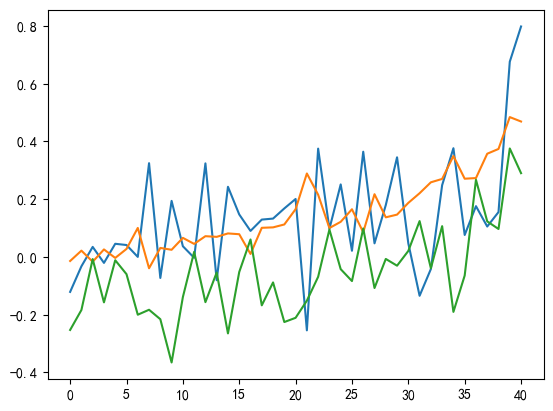

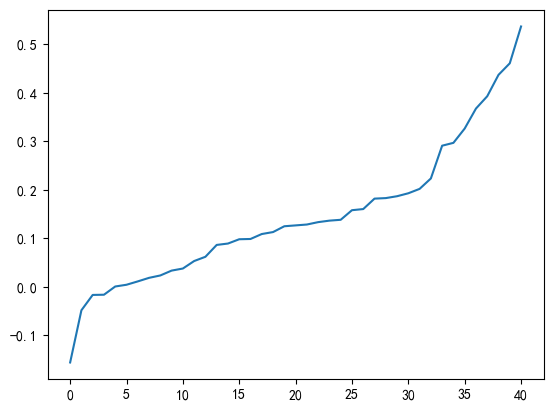

In [26]:
# 三个区域都有的几种型号的区域效应图
xAxis = [
    *filter(
        lambda x: data["Geographic Region"][data["Variant"] == x].nunique() == 3,
        data["Variant"].unique(),
    )
]
xAxis = np.array(
    sorted(xAxis, key=lambda x: data["relative"][data["Variant"] == x].mean())
)
frame = pd.DataFrame({"Varient": xAxis})
for area in regions:
    yAxis = [
        data["relative"][
            (data["Variant"] == x) & (data["Geographic Region"] == area)
        ].mean()
        for x in xAxis
    ]
    frame[f"{area}"] = yAxis
    plt.plot(range(len(yAxis)), yAxis)
frame.to_excel("grouped/regional effect of all 3 area.xlsx", index=False)
P = pd.DataFrame(
    {
        i: [
            data.loc[(data["Variant"] == x) & (data["Geographic Region"] == i)]
            .apply(lambda x: x["Listing Price (USD)"] / x["rf_HK_Price"], axis=1)
            .mean()
            for x in xAxis
        ]
        for i in regions
    }
)
K = P.apply(
    lambda p: ((p["USA"] + p["Europe"]) / p["Caribbean"] + p["USA"] / p["Europe"]) / 3
    - 1,
    axis=1,
)
order = np.argsort(K)
k_plot = pd.DataFrame({"Variant": xAxis[order], "K value": K[order]})
k_plot.to_excel("grouped/k value.xlsx", index=False)
plt.figure()
plt.plot(range(len(K)), k_plot["K value"])


(array([ 9., 31., 47., 57., 44., 34., 29., 38., 22., 24., 12., 20.,  5.,
        10.,  9., 13.,  7.,  8.,  8.,  1.,  3.,  3.,  0.,  0.,  3.,  2.,
         2.,  0.,  2.,  1.,  2.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  69000.,   97210.,  125420.,  153630.,  181840.,  210050.,
         238260.,  266470.,  294680.,  322890.,  351100.,  379310.,
         407520.,  435730.,  463940.,  492150.,  520360.,  548570.,
         576780.,  604990.,  633200.,  661410.,  689620.,  717830.,
         746040.,  774250.,  802460.,  830670.,  858880.,  887090.,
         915300.,  943510.,  971720.,  999930., 1028140., 1056350.,
        1084560., 1112770.

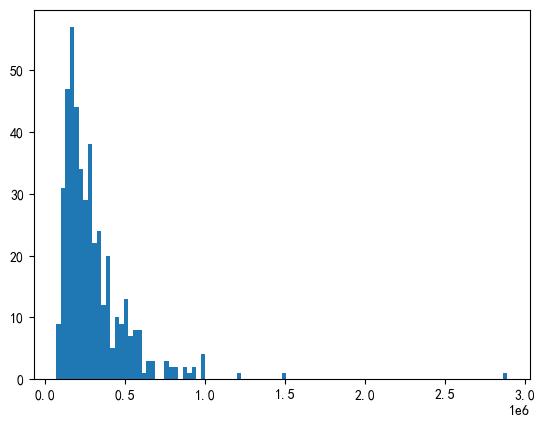

In [9]:
plt.hist(data["Listing Price (USD)"][data["Geographic Region"]=="USA"], 100)